<a href="https://colab.research.google.com/github/mapellic-siro/JuanCervigon.github.io/blob/main/Casos_de_uso_Python/Efectos_interaccion_ECV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Impacto del 1-O sobre el trabajo asalariado
## Efectos de interacción en la regressión

**Queremos explorar el efecto de un acontecimiento sobre la relación entre varias variables. Hemos seleccionado como suceso "disruptivo" los acontecimientos ocurridos en Cataluña durante el 1 de octubre de 2017 en relación al referendum convocado por el Gobierno de la Generalitat de Cataluña y suspendido cautelarmente por el Tribunal Constitucional, pese a lo cual no fue desconvocado.**  
Uno de los temas de controversia, al margen de las cuestiones políticas y legales, fue la de los efectos económicos que dicha celebración tuvo para los ciudadanos de Cataluña. Para comprobar dichos efectos hemos seleccionado la retribución salarial de cada individuo y la duración de su jornada laboral. Proponiendo como hipótesis que en caso de un efecto económico negativo del 1-O sobre la ciudadanía debería haberse notado en la retribución salarial. Además para que este efecto fuera debido a una situación específica de Cataluña, no debería haberse dado en otros territorios. Para que la comparación fuera válida el territorio de contraste debería poseer caracteristicas de potencial económico similares, motivo por el cual hemos seleccionado Madrid. 
# Tipos de datos utilizados y modelo econométrico
Para comprobar que esta relación varía a lo largo del tiempo, idealmente utilizaríamos datos de tipo longitudinal o de panel. Al no disponer de ellos realizaremos las correspondientes inferencias mediante el sistema conocido como *pooled cross-sectional*. Este tipo de datos consiste en la agregación de varias muestras estadísticas correspondientes a la misma población, pero en momentos diferentes en el tiempo. La principal diferencia entre los *pooled cross-sectional data* y los datos de panel es que los individuos seleccionados en cada periodo no son coincidentes. 
Mediante el uso de los datos pooled conseguimos aproximarnos a un diseño experimental donde tendríamos un grupo control y un grupo tratamiento. El diseño consistirá en agrupar nuestros datos de forma que en un pooled de datos tengamos una configuración before/after. Es decir, agrupando un periodo $t$ y su consecutivo $t+ 1$. Es decir, se trata de un problema de lo que en econometría se conoce como detección de un cambio estructural. Para ello vamos a utilizar una variante de la prueba de Chow (1960) a través de un modelo con variable dummy $δ$, cuya expresión general sería de la forma:  
$$y_i=β_0+τ_0 δ_i+(β_1+τ_1 δ_i)x_i+ϵ_i$$  
La variable $δ$ sería la correspondiente al año y en nuestro caso no es necesaria transformarla a valores binarios ya que el paquete ```statsmodels``` es capaz de hacerlo simplemente indicando la variable mediante una 'C' de la siguiente manera: ```C(anyo)```.  
Los coeficientes $τ_0$ nos indicarían la magnitud del efecto del tiempo (cuyo cambio contiene nuestro suceso disruptivo) y sobre todo nos importa su significatividad estadística para el contraste de hipótesis.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
sns.set()

In [ ]:
url_datos= r'https://github.com/AlejandroDGR/Proyecto_Difusion_Universitarios_INE/blob/master/Datasets/pooled_ECV.csv?raw=true'
df_panel = pd.read_csv(url_datos)
df_panel.sample(10)

,edad,sexo,comunidad,pais_nacimiento,situacion_prof,jornada_semanal,renta_cta_ajena,renta_cta_propia,anyo,ponderacion
990,68,Mujer,Catalunya,Espanya,asalariado,,27481.80,0.0,2017,355.66047
5094,43,Mujer,Catalunya,Espanya,asalariado,50,8042.90,13000.0,2017,7343.74415
7196,37,Mujer,Madrid,Resto,asalariado,40,13920.40,0.0,2017,1803.48703
15893,44,Hombre,Catalunya,Espanya,asalariado,40,41346.20,0.0,2019,253.56272
7721,20,Mujer,Catalunya,Espanya,asalariado,16,14553.98,0.0,2017,4891.78612
12240,42,Mujer,Madrid,Espanya,asalariado,,24959.80,0.0,2019,1352.28159
17648,25,Hombre,Catalunya,Espanya,asalariado,42,14567.50,0.0,2019,428.76008
8642,34,Hombre,Madrid,Espanya,asalariado,40,21598.30,0.0,2017,1882.89340
1169,36,Mujer,Catalunya,Espanya,asalariado,25,16714.90,0.0,2017,357.85249
1245,82,Mujer,Catalunya,Espanya,NaN,,0.00,0.0,2017,189.85643


In [ ]:
# reemplazamos los espacios vacios por valores perdidos
df_panel.replace(r'^\s+$', np.nan, regex=True, inplace=True)
filas_originales = df_panel.shape[0]
# eliminamos las filas con valores perdidos
df_panel.dropna(inplace=True)

# convertimos la jornada semanal en dato numérico
df_panel.jornada_semanal = pd.to_numeric(df_panel.jornada_semanal, downcast='float')

# seleccionamos aquellos que tienen rentas por cuenta ajena
df_panel = df_panel.loc[df_panel.renta_cta_ajena > 0]

# verificamos cuantas filas hemos perdido
print(f"filas perdidas = {filas_originales - df_panel.shape[0]}")
print(f"hemos perdido un {(filas_originales - df_panel.shape[0])*100/filas_originales}% de observaciones")



filas perdidas = 10394
hemos perdido un 57.003400241307446% de observaciones


In [ ]:
# funcion para visualizar distribución de una variable
def distribucion(datos, variable, bins=100):
  plt.subplot(1, 2, 1);
  sns.boxplot(x=datos['renta_cta_ajena']);
  plt.subplot(1, 2, 2);
  sns.histplot(datos['renta_cta_ajena'], bins = 100);
  plt.tight_layout();
  plt.show();

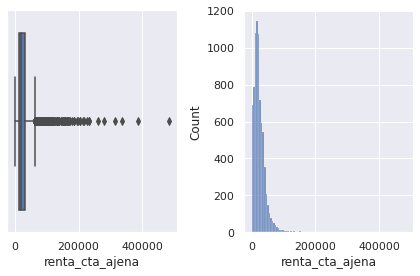

In [ ]:
# Parece haber outliers
distribucion(df_panel, 'renta_cta_ajena');

Utilizamos la regla Tukey basada en el IQR(Rango intercuartílico). 

In [ ]:
# calcular primer y tercer cuartil 
q75, q25 = np.percentile(df_panel['renta_cta_ajena'], [75, 25])

# rango IQR
iqr = q75 - q25

# determinamos los umbrales de outliers según Tukey para un factor de 1.5
offset = 1.5
limite_sup = q75 + offset*iqr
limite_inf = q25 - offset*iqr
print(f"El rango intercuartílico es: {iqr}")
print(f"El limite superior Tukey es: {limite_sup}")
print(f"El limite inferior Tukey es: {limite_inf}")

# definimos los outliers por arriba y por abajo según los umbrales calculados
outliers_inf = df_panel['renta_cta_ajena'] < limite_inf
outliers_sup = df_panel['renta_cta_ajena'] > limite_sup

# excluimos los outliers de nuestro dataset
df_panel = df_panel[~(outliers_inf | outliers_sup)].reset_index(drop=True)

El rango intercuartílico es: 20012.3
El limite superior Tukey es: 62030.75
El limite inferior Tukey es: -18018.449999999997


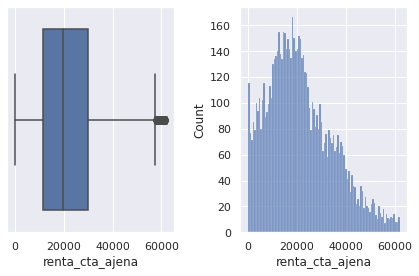

In [ ]:
# Comprobamos cómo queda la distribución de la renta sin outliers
plt.subplot(1, 2, 1)
sns.boxplot(x=df_panel['renta_cta_ajena'])
plt.subplot(1, 2, 2)
sns.histplot(df_panel['renta_cta_ajena'], bins = 100)
plt.tight_layout()
plt.show()

In [ ]:
print(f"Nos quedan {df_panel.shape[0]} observaciones en el dataset")

Nos quedan 7511 observaciones en el dataset


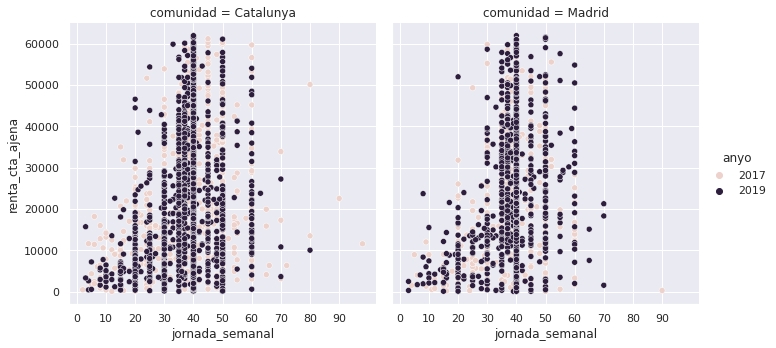

In [ ]:
# Cómo queda la distribución de nuestros datos
p = sns.relplot(x=df_panel['jornada_semanal'],  
            y=df_panel['renta_cta_ajena'],
            hue=df_panel['anyo'],
            col=df_panel['comunidad'],
            kind='scatter')
p.set(xticks=np.arange(0,100,10))
plt.show()

In [ ]:
madrid = df_panel[df_panel.comunidad=='Madrid']
catalunya = df_panel[df_panel.comunidad=='Catalunya']

interacc_cat = smf.wls(formula='renta_cta_ajena ~ jornada_semanal + C(anyo) + jornada_semanal:C(anyo)', data=catalunya).fit()
resumen_cat = interacc_cat.summary()
resumen_cat.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5374.1464,1159.717,4.634,0.000,3100.608,7647.685
C(anyo)[T.2019],-371.9673,1741.761,-0.214,0.831,-3786.558,3042.624
jornada_semanal,414.3124,29.353,14.115,0.000,356.768,471.857
jornada_semanal:C(anyo)[T.2019],3.7755,44.317,0.085,0.932,-83.104,90.655


In [ ]:
interacc_mad = smf.wls(formula='renta_cta_ajena ~ jornada_semanal + C(anyo) + jornada_semanal:C(anyo)', data=madrid).fit()
resumen_mad = interacc_mad.summary()
resumen_mad.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6634.8061,2113.796,3.139,0.002,2489.710,1.08e+04
C(anyo)[T.2019],-2251.7795,2848.732,-0.790,0.429,-7838.064,3334.505
jornada_semanal,401.9534,54.150,7.423,0.000,295.767,508.139
jornada_semanal:C(anyo)[T.2019],64.8016,72.594,0.893,0.372,-77.554,207.157


In [ ]:
interaccion = smf.wls(formula='renta_cta_ajena ~ jornada_semanal +C(comunidad)+ C(anyo)+ jornada_semanal:C(anyo):C(comunidad)', data=df_panel).fit()
resumen = interaccion.summary()
resumen.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5619.7599,1101.059,5.104,0.000,3461.376,7778.144
C(comunidad)[T.Madrid],285.0869,1632.314,0.175,0.861,-2914.706,3484.879
C(anyo)[T.2019],-925.9867,1489.472,-0.622,0.534,-3845.770,1993.796
jornada_semanal,408.2515,27.972,14.595,0.000,353.419,463.085
jornada_semanal:C(comunidad)[T.Madrid],12.0401,42.604,0.283,0.777,-71.476,95.556
jornada_semanal:C(anyo)[T.2019]:C(comunidad)[Catalunya],17.5772,38.224,0.460,0.646,-57.352,92.506
jornada_semanal:C(anyo)[T.2019]:C(comunidad)[Madrid],31.6664,39.649,0.799,0.425,-46.057,109.389


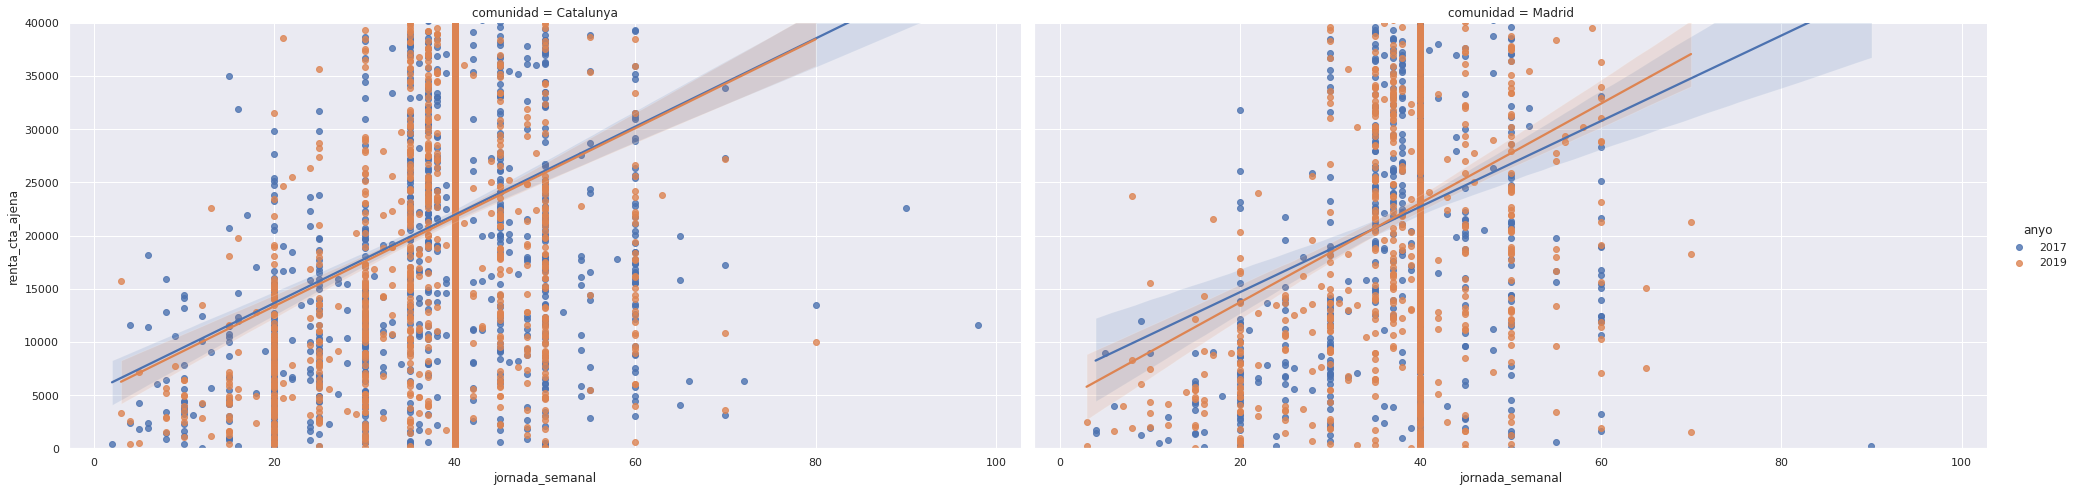

In [ ]:
a=sns.lmplot(x='jornada_semanal', y='renta_cta_ajena',col='comunidad', hue='anyo', data=df_panel, ci=95, aspect=2, height=7);
a.set(ylim=(0, 40000));